In [6]:
import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.python.ops import init_ops
import numpy as np
#import matplotlib.pyplot as plt
from copy import deepcopy, copy
import random
#%matplotlib inline

In [11]:
def get_data():
    SETS = [
    {
        "zoom": 18,
        "x": 140814,
        "y": 85975,
        "map_id": "grayschema",
        "halfspan": 50,
    },
    {
        "zoom": 18,
        "x": 140814,
        "y": 85975,
        "map_id": "mapbox.satellite",
        "halfspan": 50,
    }]

    FILE_TEMPLATE = "files/{map_id}/{zoom}/{x}/{y}.jpg"
    sat_file_paths = []
    schema_file_paths = []
    set_descr = SETS[0]
    sat_tile = deepcopy(SETS[1])
    schema_tile = deepcopy(SETS[0])
    for x in range(set_descr['x'] - set_descr['halfspan'], set_descr['x'] + set_descr['halfspan']):
        for y in range(set_descr['y'] - set_descr['halfspan'], set_descr['y'] + set_descr['halfspan']):
            sat_tile.update({"x": x, "y": y})
            schema_tile.update({"x": x, "y": y})
            sat_file_paths.append(FILE_TEMPLATE.format(**sat_tile))
            schema_file_paths.append(FILE_TEMPLATE.format(**schema_tile))

    bad_schema_file_paths = copy(schema_file_paths)
    random.shuffle(bad_schema_file_paths)

    data = []
    for sat_path, schema_path in zip(sat_file_paths, schema_file_paths):
        data.append((sat_path, schema_path, 1, 0))
    for sat_path, schema_path in zip(sat_file_paths, bad_schema_file_paths):
        data.append((sat_path, schema_path, 0, 1))

    random.shuffle(data)
    sat_file_paths = []
    schema_file_paths = []
    labels = []
    for item in data:
        sat_file_paths.append(item[0])
        schema_file_paths.append(item[1])
        labels.append(item[2:4])

    return sat_file_paths, schema_file_paths, labels

In [12]:
def splittvt(arr, frac):
    count = len(arr)
    valid_start = int(count * (1-2*frac))
    test_start = int(count * (1-frac))
    return arr[:valid_start], arr[valid_start: test_start], arr[test_start:]

sat_file_paths, schema_file_paths, labels = get_data()
TST_FRAC = 0.2
train_sat_paths, valid_sat_paths, test_sat_paths = splittvt(sat_file_paths, TST_FRAC)
train_map_paths, valid_map_paths, test_map_paths = splittvt(schema_file_paths, TST_FRAC)
train_labels, valid_labels, test_labels = splittvt(labels, TST_FRAC)
#valid_sat_paths = train_sat_paths
#valid_map_paths = train_map_paths
#valid_labels = train_labels
print len(train_sat_paths), len(valid_sat_paths), len(test_sat_paths)

12000 4000 4000


In [16]:
EPOCHS = 2000
IMG_SIZE = 256
batch_size = 256

def read_img(path, f):
    if f == 'png':
        return -1 + tf.cast(tf.image.decode_png(tf.read_file(path)), tf.float32)/128.0
    else:
        return -1 + tf.cast(tf.image.decode_jpeg(tf.read_file(path)), tf.float32)/128.0

def model(data, is_training):
    conv = data
    conv = slim.dropout(
        slim.conv2d(conv,
            activation_fn=tf.nn.relu,
            biases_initializer=init_ops.constant_initializer(0.001),
            num_outputs=8, kernel_size=[5,5], stride=2, padding='SAME'),
        is_training=is_training)
    conv = slim.dropout(
        slim.conv2d(conv,
            activation_fn=tf.nn.relu,
            biases_initializer=init_ops.constant_initializer(0.001),
            num_outputs=16, kernel_size=[5,5], stride=2, padding='SAME'),
        is_training=is_training)
    conv = slim.dropout(
        slim.conv2d(conv,
            activation_fn=tf.nn.relu,
            biases_initializer=init_ops.constant_initializer(0.001),
            num_outputs=16, kernel_size=[5,5], stride=2, padding='SAME'),
        is_training=is_training)
    
    shape = conv.get_shape().as_list()
    hidden = tf.reshape(conv, shape=[shape[0], shape[1] * shape[2] * shape[3]])
    hidden = slim.dropout(
        slim.fully_connected(
            hidden,
            num_outputs=128),
        is_training=is_training)
    hidden = slim.fully_connected(hidden, num_outputs=64)

    logits = slim.fully_connected(hidden, num_outputs=2, activation_fn=None)
    return logits

graph = tf.Graph()
with graph.as_default():
    tf_is_training = tf.placeholder_with_default(True, shape=())
    tf_map_files = tf.placeholder(tf.string, shape=[batch_size])
    tf_sat_files = tf.placeholder(tf.string, shape=[batch_size])
    tf_labels = tf.placeholder(tf.float32, shape=[batch_size, 2])
    
    tf_data = tf.reshape(tf.concat([
            tf.stack([read_img(path, 'png') for path in tf.unstack(tf_map_files)]),
            tf.stack([read_img(path, 'jpg') for path in tf.unstack(tf_sat_files)])
        ],3), [batch_size, IMG_SIZE, IMG_SIZE, 4])
    
    logits = model(tf_data, tf_is_training)
    
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=tf_labels))
    tf.summary.scalar('loss_5', loss)
    global_step = tf.Variable(0)
    learn_rate = tf.train.exponential_decay(0.1, global_step, 1000, 0.9)
    tf.summary.scalar('learnrate_5', learn_rate)
    optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(
        loss, global_step=global_step)
    
    prediction = tf.nn.softmax(logits)
    correct = tf.nn.in_top_k(logits, tf.arg_max(tf_labels, 1), 1)
    count_correct = tf.count_nonzero(correct)
    merged = tf.summary.merge_all()

In [ ]:
train_writer = tf.summary.FileWriter("./summary")

def doEpoch(session, epoch):
    train_loss = 0.0
    correct = 0
    for step in range((len(train_map_paths) - batch_size) // batch_size + 1):
        offset = (step * batch_size) % (len(train_map_paths) - batch_size + 1)
        feed_dict={
            tf_map_files: train_map_paths[offset:offset+batch_size],
            tf_sat_files: train_sat_paths[offset:offset+batch_size],
            tf_labels: train_labels[offset:offset+batch_size]
        }
        _,l,c,ms, gs = session.run([optimizer, loss, count_correct, merged, global_step], feed_dict=feed_dict)
        train_loss += l
        correct += c
        train_writer.add_summary(ms, gs)

    return l, train_loss / ((len(train_map_paths) - batch_size) // batch_size + 1), correct
    
def doValidate(session):
    valid_correct = 0
    for step in range((len(valid_map_paths) - batch_size) // batch_size + 1):
        offset = (step * batch_size) % (len(valid_map_paths) - batch_size + 1)
        feed_dict={
            tf_map_files: valid_map_paths[offset:offset+batch_size],
            tf_sat_files: valid_sat_paths[offset:offset+batch_size],
            tf_labels: valid_labels[offset:offset+batch_size],
            tf_is_training: False
        }
        l, c = session.run([loss, count_correct], feed_dict=feed_dict)
        valid_correct += c
    return (1.0 * valid_correct) / len(valid_map_paths)

with tf.Session(graph=graph) as session: 
    tf.global_variables_initializer().run()
    print "Initialized."
    for epoch in range(EPOCHS):
        last_loss, train_loss, correct = doEpoch(session, epoch)
        accuracy = doValidate(session)
        if epoch % 20 == 1:
            print "{} loss: {:.6f}, acc: {:.6f} {}".format(epoch, train_loss, accuracy, correct)
        print "Final loss: {:.6f}, acc: {:.6f} {}".format(train_loss, accuracy, correct)

Initialized.
Final loss: 0.694606, acc: 0.474750 5856
1 loss: 0.694008, acc: 0.476250 5870
Final loss: 0.694008, acc: 0.476250 5870
Final loss: 0.693845, acc: 0.476250 5817
Final loss: 0.693011, acc: 0.476750 5891
Final loss: 0.693332, acc: 0.476500 5882
Final loss: 0.693126, acc: 0.474500 5966
Final loss: 0.693113, acc: 0.475500 5950
Final loss: 0.693039, acc: 0.476000 5992
Final loss: 0.693358, acc: 0.476500 5836
Final loss: 0.693163, acc: 0.476500 5887
Final loss: 0.693256, acc: 0.476500 5915
Final loss: 0.693167, acc: 0.477000 5927
Final loss: 0.692483, acc: 0.471750 6024
Final loss: 0.692817, acc: 0.469750 6050
Final loss: 0.692745, acc: 0.461750 5996
Final loss: 0.692561, acc: 0.466000 6047
Final loss: 0.693277, acc: 0.475500 5865
Final loss: 0.692424, acc: 0.469500 6021
Final loss: 0.692187, acc: 0.465250 6039
Final loss: 0.692243, acc: 0.477000 5976
Final loss: 0.692263, acc: 0.477500 6058
21 loss: 0.691276, acc: 0.474500 6124
Final loss: 0.691276, acc: 0.474500 6124
Final loss

In [22]:
tf.nn.in_top_k?

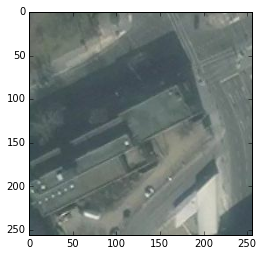

In [30]:
plt.imshow((b[0][:,:,1:4] * 128  + 128).astype(np.uint8))

In [21]:
b[0][:,:,1:3].shape

(256, 256, 2)

In [186]:

with tf.Session(graph=graph) as session: 
    tf.global_variables_initializer().run()
    print "Initialized."

    offset = 0
    feed_dict={
        tf_map_files: train_map_paths[offset:offset+batch_size],
        tf_sat_files: train_sat_paths[offset:offset+batch_size],
        tf_labels: train_labels[offset:offset+batch_size],
        tf_is_training: False
    }
    p,l,c = session.run([prediction, loss, count_correct], feed_dict=feed_dict)


Initialized.


In [187]:
print p,l,c

[[ 0.49481392  0.50518608]
 [ 0.42416078  0.57583922]
 [ 0.55655682  0.44344318]
 [ 0.34069428  0.65930575]
 [ 0.52030444  0.47969562]
 [ 0.55366307  0.4463369 ]
 [ 0.48340487  0.51659513]
 [ 0.52761281  0.47238716]
 [ 0.37108296  0.62891704]
 [ 0.50672543  0.49327466]
 [ 0.55860054  0.44139943]
 [ 0.49773648  0.50226349]
 [ 0.43587902  0.56412101]
 [ 0.27410066  0.72589934]
 [ 0.49598411  0.50401592]
 [ 0.4966383   0.50336176]
 [ 0.43395162  0.56604838]
 [ 0.47699109  0.52300894]
 [ 0.55994332  0.44005674]
 [ 0.46872115  0.53127885]
 [ 0.51650125  0.48349872]
 [ 0.52361602  0.47638395]
 [ 0.45257035  0.54742968]
 [ 0.57365453  0.4263455 ]
 [ 0.46919391  0.53080601]
 [ 0.61332744  0.38667253]
 [ 0.5158813   0.48411861]
 [ 0.55200624  0.44799376]
 [ 0.43767318  0.56232679]
 [ 0.32657078  0.67342913]
 [ 0.46009493  0.53990501]
 [ 0.49172115  0.50827879]
 [ 0.44803533  0.5519647 ]
 [ 0.55210859  0.44789132]
 [ 0.49835005  0.50164998]
 [ 0.36103165  0.63896835]
 [ 0.53809786  0.46190214]
 

In [15]:
slim.convolution?

In [129]:
graph.get_collection('variables')[0].name

u'fully_connected/weights:0'

In [115]:
tf.GraphKeys.TRAINABLE_VARIABLES 

'trainable_variables'

In [127]:
tf.Variable?